# Important Variable

In [1]:
#!jupyter nbconvert --to script model_build.ipynb

import csv
import json
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt, welch
from scipy.signal import resample
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import matplotlib.colors as mcolors
import random


2024-09-17 20:34:28.684131: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 20:34:28.704517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 20:34:28.730983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 20:34:28.731007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 20:34:28.747483: I tensorflow/core/platform/cpu_feature_gua

In [2]:
print(tf.__version__)

2.16.2


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-09-17 20:34:37.934280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 38 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-09-17 20:34:37.936261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 8576 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-17 20:34:37.937869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 8576 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-09-17 20:34:37.939202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 8576 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
2024-09-17 20:34:37.940427: I tensorflow/core/common_runtime/gpu/g

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10754582270604962087
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40370176
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13204773798133685267
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 8993112064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6662748032913044546
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 8993112064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4527576462662268828
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5"
 xla_gl

/gpu_device.cc:1928] Created device /device:GPU:5 with 8576 MB memory:  -> device: 5, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5
2024-09-17 20:34:37.942787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:6 with 8576 MB memory:  -> device: 6, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2024-09-17 20:34:37.943950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:7 with 8576 MB memory:  -> device: 7, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


In [4]:
pd.set_option('future.no_silent_downcasting', True)

In [5]:
MODEL_NAME = 'test'
RUN = 'run0_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = r'/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery/
/nfs/ada/jbrook1/users/qdang1/Descartes/Cognitive_battery_dissertation/output/run0_test/


# Load data

In [6]:
df_eye = pd.read_pickle(DATA_DIR + 'df_eye.pkl')
df_temp = df_eye['eye_data'].apply(lambda x: pd.Series(x))
df_eye = pd.concat([df_eye.drop('eye_data', axis=1), df_temp], axis=1)
df_eye

,subject_id,game_type,Timestamp,Gaze_X,Gaze_Y,Pupil_left,Pupil_right
0,BVCX,baseline,"[1710352642777.923, 1710352642769.658, 1710352...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, 2.95977783203125, 2.9902648925781..."
1,BVCX,enumeration,"[1710354603794.525, 1710354603817.258, 1710354...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
2,BVCX,task_switching,"[1710354023688.477, 1710354023752.989, 1710354...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
3,BVCX,working_memory,"[1710353127527.266, 1710353127549.055, 1710353...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
4,CVBN,baseline,"[1710444817133.011, 1710444817145.584, 1710444...","[None, 0.5115212798118591, 0.5106108784675598,...","[None, 0.5157326459884644, 0.5222259759902954,...","[None, 3.527740478515625, 3.4796142578125, 3.4...","[None, 3.4715728759765625, 3.43231201171875, 3..."
...,...,...,...,...,...,...,...
395,YTRE,baseline,"[1711637695846.3, 1711637695859.122, 171163769...","[None, 0.6326038837432861, 0.6315056681632996,...","[None, 0.9230542778968812, 0.912976622581482, ...","[None, 3.5099639892578125, 3.4502410888671875,...","[None, 3.8503570556640634, 3.84893798828125, 4..."
396,YTRE,enumeration,"[1711638199400.047, 1711638199420.487, 1711638...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
397,YTRE,task_switching,"[1711638876414.245, 1711638876434.547, 1711638...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
398,YTRE,working_memory,"[1711639643643.328, 1711639643655.342, 1711639...","[None, 0.2366343736648559, 0.2209111005067825,...","[None, 0.4480386972427368, 0.4117077887058258,...","[None, 3.949371337890625, 3.9755706787109375, ...","[None, 4.4937744140625, 4.55987548828125, 4.94..."


In [7]:
df_ecg = pd.read_pickle(DATA_DIR + 'df_sensor.pkl')
df_temp = df_ecg['data'].apply(lambda x: pd.Series(x))
df_ecg = pd.concat([df_ecg.drop('data', axis=1), df_temp.drop('eda_data',axis=1)], axis=1)
df_ecg

,subject_id,game_type,Timestamp,ecg_data
0,BVCX,baseline,"[1710352670.22933, 1710352670.23333, 171035267...","[210.0, 215.0, 210.0, 203.0, 166.0, 132.0, 133..."
1,BVCX,enumeration,"[1710354601.587721, 1710354601.591721, 1710354...","[236.0, 239.0, 234.0, 236.0, 237.0, 233.0, 239..."
2,BVCX,task_switching,"[1710354051.4275117, 1710354051.4315114, 17103...","[180.0, 178.0, 157.0, 155.0, 153.0, 163.0, 156..."
3,BVCX,working_memory,"[1710353155.3258922, 1710353155.3298922, 17103...","[418.0, 363.0, 272.0, 202.0, 179.0, 157.0, 137..."
4,CVBN,baseline,"[1710444844.91457, 1710444844.9185698, 1710444...","[207.0, 203.0, 200.0, 196.0, 188.0, 193.0, 186..."
...,...,...,...,...
395,YTRE,baseline,"[1711637723.7361555, 1711637723.7401557, 17116...","[144.0, 142.0, 137.0, 133.0, 112.0, 108.0, 106..."
396,YTRE,enumeration,"[1711638227.2988112, 1711638227.3028111, 17116...","[199.0, 202.0, 207.0, 197.0, 203.0, 209.0, 213..."
397,YTRE,task_switching,"[1711638904.316353, 1711638904.320353, 1711638...","[676.0, 525.0, 346.0, 202.0, 140.0, 136.0, 143..."
398,YTRE,working_memory,"[1711639671.503046, 1711639671.507046, 1711639...","[221.0, 211.0, 207.0, 207.0, 209.0, 203.0, 207..."


In [8]:
df_enumeration = pd.read_pickle(DATA_DIR + 'df_enumeration.pkl')
df_temp = df_enumeration['data'].apply(lambda x: pd.Series(x))
df_enumeration = pd.concat([df_enumeration.drop('data', axis=1), df_temp], axis=1)
df_enumeration = df_enumeration.explode(['Blockno','Difficulty','Start_time','End_time','Results_Responses','Results_rt','Results_targetvalue','Accuracy'])
columns_to_cast = [
    'Start_time', 'End_time', 'Results_Responses', 'Results_rt', 
    'Results_targetvalue', 'Accuracy',
    'Accuracy_Easy', 'Accuracy_Medium', 'Accuracy_Hard', 'Accuracy_Overall'
]
# Cast specified columns to float64
df_enumeration[columns_to_cast] = df_enumeration[columns_to_cast].astype('float64')
df_enumeration['Task_type'] = 'enumeration'

print(df_enumeration.dtypes)
df_enumeration

userid                  object
Blockno                 object
Difficulty              object
Start_time             float64
End_time               float64
Results_Responses      float64
Results_rt             float64
Results_targetvalue    float64
Accuracy               float64
Task_type               object
Accuracy_Easy          float64
Accuracy_Medium        float64
Accuracy_Hard          float64
Accuracy_Overall       float64
dtype: object


,userid,Blockno,Difficulty,Start_time,End_time,Results_Responses,Results_rt,Results_targetvalue,Accuracy,Task_type,Accuracy_Easy,Accuracy_Medium,Accuracy_Hard,Accuracy_Overall
0,BVCX,1,Easy,1.710355e+12,1.710355e+12,8.0,2008.0,9.0,0.0,enumeration,0.90,0.55,0.3,0.583333
0,BVCX,1,Easy,1.710355e+12,1.710355e+12,8.0,1241.0,8.0,1.0,enumeration,0.90,0.55,0.3,0.583333
0,BVCX,1,Easy,1.710355e+12,1.710355e+12,9.0,1660.0,9.0,1.0,enumeration,0.90,0.55,0.3,0.583333
0,BVCX,1,Easy,1.710355e+12,1.710355e+12,6.0,1247.0,6.0,1.0,enumeration,0.90,0.55,0.3,0.583333
0,BVCX,1,Easy,1.710355e+12,1.710355e+12,5.0,1428.0,5.0,1.0,enumeration,0.90,0.55,0.3,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,YTRE,3,Easy,1.711639e+12,1.711639e+12,8.0,2602.0,8.0,1.0,enumeration,0.85,0.45,0.4,0.566667
99,YTRE,3,Easy,1.711639e+12,1.711639e+12,8.0,2018.0,8.0,1.0,enumeration,0.85,0.45,0.4,0.566667
99,YTRE,3,Easy,1.711639e+12,1.711639e+12,8.0,6168.0,7.0,0.0,enumeration,0.85,0.45,0.4,0.566667
99,YTRE,3,Easy,1.711639e+12,1.711639e+12,8.0,2400.0,7.0,0.0,enumeration,0.85,0.45,0.4,0.566667


In [9]:
df_ts = pd.read_pickle(DATA_DIR + 'df_task_switch.pkl')
df_temp = df_ts['data'].apply(lambda x: pd.Series(x))
df_ts = pd.concat([df_ts.drop('data', axis=1), df_temp], axis=1)
df_ts = df_ts.explode(['Blockno','Difficulty','Start_time','End_time','Results_Responses','Results_rt','Results_ind_switch','Results_indtask','Results_trail_target','Correct action','Hit/Miss','Accuracy'])
df_ts = df_ts.replace({'None':np.nan})
df_ts = df_ts[df_ts['Start_time'] != 0] # Drop rows where Start_time is 0
df_ts['End_time'] = df_ts.apply(lambda row: row['Start_time'] + 3000 if pd.isna(row['End_time']) else row['End_time'], axis=1) # Fill NaN values in End_time with Start_time + 3000
df_ts['Results_rt'] = df_ts['Results_rt'].fillna(3000) # Fill NaN values in Results_rt with 300
columns_to_cast = [
    'Start_time', 'End_time', 'Results_Responses', 'Results_rt', 
    'Results_ind_switch', 'Results_indtask', 'Results_trail_target', 
    'Correct action', 'Hit/Miss', 'Accuracy',
    'Accuracy_Easy', 'Accuracy_Medium', 'Accuracy_Hard', 'Accuracy_Overall'
]
# Cast specified columns to float64
df_ts[columns_to_cast] = df_ts[columns_to_cast].astype('float64')
df_ts['Task_type'] = 'task_switching'
print(df_ts.dtypes)
df_ts

userid                   object
Blockno                  object
Difficulty               object
Start_time              float64
End_time                float64
Results_Responses       float64
Results_rt              float64
Results_ind_switch      float64
Results_indtask         float64
Results_trail_target    float64
Correct action          float64
Hit/Miss                float64
Accuracy                float64
Task_type                object
Accuracy_Easy           float64
Accuracy_Medium         float64
Accuracy_Hard           float64
Accuracy_Overall        float64
dtype: object


,userid,Blockno,Difficulty,Start_time,End_time,Results_Responses,Results_rt,Results_ind_switch,Results_indtask,Results_trail_target,Correct action,Hit/Miss,Accuracy,Task_type,Accuracy_Easy,Accuracy_Medium,Accuracy_Hard,Accuracy_Overall
0,BVCX,1,Hard,1.710354e+12,1.710354e+12,1.0,880.0,0.0,1.0,1.0,1.0,1.0,1.0,task_switching,0.802469,0.888889,0.469136,0.720165
0,BVCX,1,Hard,1.710354e+12,1.710354e+12,0.0,3000.0,1.0,1.0,7.0,2.0,0.0,0.0,task_switching,0.802469,0.888889,0.469136,0.720165
0,BVCX,1,Hard,1.710354e+12,1.710354e+12,0.0,3000.0,0.0,0.0,4.0,2.0,0.0,0.0,task_switching,0.802469,0.888889,0.469136,0.720165
0,BVCX,1,Hard,1.710354e+12,1.710354e+12,1.0,940.0,1.0,0.0,1.0,1.0,1.0,1.0,task_switching,0.802469,0.888889,0.469136,0.720165
0,BVCX,1,Hard,1.710354e+12,1.710354e+12,1.0,580.0,0.0,1.0,2.0,1.0,1.0,1.0,task_switching,0.802469,0.888889,0.469136,0.720165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,YTRE,3,Hard,1.711639e+12,1.711639e+12,1.0,679.0,1.0,1.0,4.0,1.0,1.0,1.0,task_switching,0.925926,0.962963,0.888889,0.925926
99,YTRE,3,Hard,1.711639e+12,1.711639e+12,0.0,3000.0,1.0,0.0,2.0,2.0,0.0,0.0,task_switching,0.925926,0.962963,0.888889,0.925926
99,YTRE,3,Hard,1.711639e+12,1.711639e+12,2.0,901.0,1.0,1.0,9.0,2.0,1.0,1.0,task_switching,0.925926,0.962963,0.888889,0.925926
99,YTRE,3,Hard,1.711639e+12,1.711639e+12,1.0,701.0,1.0,0.0,7.0,1.0,1.0,1.0,task_switching,0.925926,0.962963,0.888889,0.925926


In [10]:
df_wm = pd.read_pickle(DATA_DIR + 'df_working_memory.pkl')
df_temp = df_wm['data'].apply(lambda x: pd.Series(x))
df_wm = pd.concat([df_wm.drop('data', axis=1), df_temp], axis=1)
df_wm = df_wm.explode(['BlockNo','Difficulty','Start_time','End_time','Results_responses','Results_rt','Results_targetvalue_stim','Results_num_stim','Results_correct','Correct Answer','Accuracy'])
columns_to_cast = [
    'Start_time', 'End_time', 'Results_rt', 
    'Results_num_stim', 'Results_correct', 'Accuracy',
    'Accuracy_Easy', 'Accuracy_Medium', 'Accuracy_Hard', 'Accuracy_Overall'
]
# Cast specified columns to float64
df_wm[columns_to_cast] = df_wm[columns_to_cast].astype('float64')
df_wm['Task_type'] = 'working_memory'
df_wm['Accuracy'] = df_wm['Results_correct']   #overwrite it, Don't want partical Accuracy
print(df_wm.dtypes)
df_wm

userid                       object
BlockNo                      object
Difficulty                   object
Start_time                  float64
End_time                    float64
Results_responses            object
Results_rt                  float64
Results_targetvalue_stim     object
Results_num_stim            float64
Results_correct             float64
Correct Answer               object
Accuracy                    float64
Task_type                    object
Accuracy_Easy               float64
Accuracy_Medium             float64
Accuracy_Hard               float64
Accuracy_Overall            float64
dtype: object


,userid,BlockNo,Difficulty,Start_time,End_time,Results_responses,Results_rt,Results_targetvalue_stim,Results_num_stim,Results_correct,Correct Answer,Accuracy,Task_type,Accuracy_Easy,Accuracy_Medium,Accuracy_Hard,Accuracy_Overall
0,BVCX,1,Easy,1.710353e+12,1.710353e+12,0-1-2-3,2060.0,5-11-8-13-2-7-1-14-12-3-10-6-15-9-0-4,4.0,1.0,0-1-2-3,1.0,working_memory,1.0,0.833333,0.531250,0.788194
0,BVCX,1,Easy,1.710353e+12,1.710353e+12,0-1-2-3,2200.0,7-3-6-14-4-5-8-12-9-13-11-10-0-15-2-1,4.0,1.0,0-1-2-3,1.0,working_memory,1.0,0.833333,0.531250,0.788194
0,BVCX,1,Easy,1.710353e+12,1.710353e+12,0-1-2,2100.0,7-2-11-9-4-14-8-15-10-6-12-3-1-0-13-5,3.0,1.0,0-1-2,1.0,working_memory,1.0,0.833333,0.531250,0.788194
0,BVCX,1,Easy,1.710353e+12,1.710353e+12,0-1-2-3,2720.0,12-14-13-11-4-15-8-3-7-2-0-5-10-1-9-6,4.0,1.0,0-1-2-3,1.0,working_memory,1.0,0.833333,0.531250,0.788194
0,BVCX,1,Easy,1.710353e+12,1.710353e+12,0-1-2,1980.0,9-13-10-1-11-14-7-12-3-5-15-8-2-0-4-6,3.0,1.0,0-1-2,1.0,working_memory,1.0,0.833333,0.531250,0.788194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,YTRE,3,Medium,1.711640e+12,1.711640e+12,0-1-2-3-4,4060.0,14-4-15-0-12-9-7-6-13-11-8-1-3-10-2-5,5.0,1.0,0-1-2-3-4,1.0,working_memory,1.0,0.946667,0.659821,0.868829
96,YTRE,3,Medium,1.711640e+12,1.711640e+12,0-1-2-3-4-5,2420.0,8-15-11-0-9-1-14-6-3-10-4-12-7-5-2-13,6.0,1.0,0-1-2-3-4-5,1.0,working_memory,1.0,0.946667,0.659821,0.868829
96,YTRE,3,Medium,1.711640e+12,1.711640e+12,0-1-2-3-4,2160.0,6-0-4-13-3-5-2-12-10-11-9-1-7-8-14-15,5.0,1.0,0-1-2-3-4,1.0,working_memory,1.0,0.946667,0.659821,0.868829
96,YTRE,3,Medium,1.711640e+12,1.711640e+12,0-1-2-3-4-5,2620.0,8-3-12-0-5-7-9-13-11-10-15-6-1-14-4-2,6.0,1.0,0-1-2-3-4-5,1.0,working_memory,1.0,0.946667,0.659821,0.868829


In [11]:
df_demo = pd.read_csv(DATA_DIR + 'data_100_subjectid_demographic_gaming_exp.csv',index_col=False)
df_demo = df_demo.iloc[:,:18]
cat_columns = ['Gender', 'Race', 'Education', 'Smote_frequently', 'Caffeine_Consumption',
               'Q2_How long have you played games','Q3_how often do you currently play video games?',
               'Q4_During the average week how many hours do you currently spend playing video games?',
               'Q5_When you play video games how many hours do you usually spend playing',
               'Q6_How skilled do you feel you are at playing video games'
              ]
df_demo[cat_columns] = df_demo[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_demo

,subject_id,Age,Gender,Race,Education,Smote_frequently,Caffeine_Consumption,Q2_How long have you played games,Q3_how often do you currently play video games?,Q4_During the average week how many hours do you currently spend playing video games?,Q5_When you play video games how many hours do you usually spend playing,Q6_How skilled do you feel you are at playing video games,Q7_Please rate your experience playing video games on a scale of 1 (very inexperienced) to 7 (very experienced).,"Q8_Please rate each of the following game genres based on your preference, on a scale from 1 (Least Preferred) to 5 (Most Preferred). - First-person shooter","Q9_Please rate each of the following game genres based on your preference, on a scale from 1 (Least Preferred) to 5 (Most Preferred). - Realistic military","Q10_Please rate each of the following game genres based on your preference, on a scale from 1 (Least Preferred) to 5 (Most Preferred). - Driving or Racing","Q11_Please rate each of the following game genres based on your preference, on a scale from 1 (Least Preferred) to 5 (Most Preferred). - Strategy","Q12_Please rate each of the following game genres based on your preference, on a scale from 1 (Least Preferred) to 5 (Most Preferred). - Role-playing"
0,HPLX,19,0,0,0,0,0,0,0,0,0,0,6,5,2,4,3,4
1,TYDF,20,0,1,0,0,1,1,1,1,1,1,6,4,3,2,4,3
2,JFDE,22,0,2,1,0,2,1,1,1,0,0,5,5,1,3,3,2
3,UJNH,20,0,1,1,0,3,1,2,2,2,0,7,2,3,1,5,5
4,MNBW,21,0,3,0,0,1,1,0,0,2,2,7,5,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,RIQW,18,0,3,1,0,0,1,0,4,2,0,6,5,3,3,1,4
96,LKPW,20,0,0,0,0,3,1,0,2,0,0,5,5,1,4,3,4
97,VFTY,25,0,2,2,2,4,1,1,4,2,0,7,5,2,3,4,1
98,POIU,24,0,2,2,3,0,1,1,1,0,0,5,4,4,5,5,5


In [12]:
df_ecg_baseline = df_ecg[df_ecg['game_type'] == 'baseline'].copy().reset_index(drop=True)
df_ecg_baseline

,subject_id,game_type,Timestamp,ecg_data
0,BVCX,baseline,"[1710352670.22933, 1710352670.23333, 171035267...","[210.0, 215.0, 210.0, 203.0, 166.0, 132.0, 133..."
1,CVBN,baseline,"[1710444844.91457, 1710444844.9185698, 1710444...","[207.0, 203.0, 200.0, 196.0, 188.0, 193.0, 186..."
2,DKLQ,baseline,"[1707850457.359229, 1707850457.363229, 1707850...","[240.0, 141.0, 151.0, 129.0, 109.0, 136.0, 150..."
3,EDFR,baseline,"[1710265285.1534605, 1710265285.1574605, 17102...","[221.0, 222.0, 205.0, 215.0, 194.0, 211.0, 208..."
4,FDSA,baseline,"[1712166375.4756374, 1712166375.4796374, 17121...","[188.0, 177.0, 159.0, 150.0, 154.0, 157.0, 159..."
...,...,...,...,...
95,SRKLP,baseline,"[1698955031.2723727, 1698955031.276373, 169895...","[115.0, 63.0, 47.0, 58.0, 86.0, 105.0, 123.0, ..."
96,VFTY,baseline,"[1709832227.666559, 1709832227.670559, 1709832...","[211.0, 207.0, 208.0, 190.0, 176.0, 175.0, 182..."
97,XUYP,baseline,"[1710341584.714779, 1710341584.7187788, 171034...","[254.0, 239.0, 221.0, 230.0, 244.0, 225.0, 206..."
98,YTRE,baseline,"[1711637723.7361555, 1711637723.7401557, 17116...","[144.0, 142.0, 137.0, 133.0, 112.0, 108.0, 106..."


In [13]:
df_eye_baseline = df_eye[df_eye['game_type'] == 'baseline'].copy().reset_index(drop=True)
df_eye_baseline

,subject_id,game_type,Timestamp,Gaze_X,Gaze_Y,Pupil_left,Pupil_right
0,BVCX,baseline,"[1710352642777.923, 1710352642769.658, 1710352...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, 2.95977783203125, 2.9902648925781..."
1,CVBN,baseline,"[1710444817133.011, 1710444817145.584, 1710444...","[None, 0.5115212798118591, 0.5106108784675598,...","[None, 0.5157326459884644, 0.5222259759902954,...","[None, 3.527740478515625, 3.4796142578125, 3.4...","[None, 3.4715728759765625, 3.43231201171875, 3..."
2,DKLQ,baseline,"[1707850429565.024, 1707850429573.776, 1707850...","[None, 0.6133841276168823, 0.6234439611434937,...","[None, 0.9573578238487244, 0.9330644607543944,...","[None, 2.8625030517578125, 2.7835693359375, 2....","[None, 2.878997802734375, 2.8289794921875, 2.9..."
3,EDFR,baseline,"[1710265257695.891, 1710265257697.521, 1710265...","[None, 0.04992001876235, 0.1030798777937889, 0...","[None, 0.8457838296890259, 0.8645687103271484,...","[None, 4.15936279296875, 3.953216552734375, 3....","[None, 4.186492919921875, 4.05596923828125, 4...."
4,FDSA,baseline,"[1712166377668.038, 1712166377689.806, 1712166...","[None, None, 0.7373125553131104, 0.73415738344...","[None, None, 0.7908896803855896, 0.80262535810...","[None, None, 3.0050048828125, 3.08769226074218...","[None, 3.4166412353515625, 3.30780029296875, 3..."
...,...,...,...,...,...,...,...
95,SRKLP,baseline,"[1698955033420.379, 1698955033431.155, 1698955...","[None, 0.0578911826014518, 0.0484308674931526,...","[None, 1.3561601638793943, 1.3524566888809204,...","[None, 3.340423583984375, 3.282989501953125, 3...","[None, 3.436431884765625, 3.4036102294921875, ..."
96,VFTY,baseline,"[1709832200300.246, 1709832200347.841, 1709832...","[None, None, None, None, 0.485287994146347, 0....","[None, None, None, None, 0.8541511297225952, 0...","[None, None, None, None, 4.0523834228515625, 4...","[None, None, 3.538925170898437, None, 3.834335..."
97,XUYP,baseline,"[1710341556880.562, 1710341556892.098, 1710341...","[None, 0.5102744102478027, 0.5087376832962036,...","[None, 0.4398336410522461, 0.4239110946655273,...","[None, 3.1533966064453125, 3.156982421875, 3.4...","[None, 2.93902587890625, 2.936798095703125, 3...."
98,YTRE,baseline,"[1711637695846.3, 1711637695859.122, 171163769...","[None, 0.6326038837432861, 0.6315056681632996,...","[None, 0.9230542778968812, 0.912976622581482, ...","[None, 3.5099639892578125, 3.4502410888671875,...","[None, 3.8503570556640634, 3.84893798828125, 4..."


# Constant Variable

In [14]:
UNIQUE_SID = df_eye['subject_id'].unique()
elements_to_remove = ['HGFD', 'BVCX'] #too much noise
UNIQUE_SID = UNIQUE_SID[~np.isin(UNIQUE_SID, elements_to_remove)]
UNIQUE_SID

array(['CVBN', 'DKLQ', 'EDFR', 'FDSA', 'FGHZ', 'JHGF', 'JKLZ', 'MYTZ',
       'NMBV', 'NMKL', 'PKJH', 'PLMO', 'QPMN', 'QWER', 'QWRT', 'QXZW',
       'SBQRG', 'SJWQP', 'SVTZM', 'SXVBN', 'TGVB', 'TYDF', 'WERT', 'WZXE',
       'XZPT', 'YUZW', 'ZXAS', 'ZXWE', 'ZYXW', 'BHGY', 'HJKL', 'JFDE',
       'JKLM', 'KJHG', 'LKJH', 'LPDW', 'MJKL', 'MJUY', 'NBVC', 'NVBX',
       'QAXY', 'QPLM', 'REWQ', 'RIQW', 'RTGH', 'SBTBT', 'SNMVN', 'TYZX',
       'UIOP', 'UYGH', 'VIWZ', 'VNPL', 'XCVH', 'XRTY', 'ZRTY', 'ZXCJ',
       'ZXCV', 'ZXNM', 'FTLD', 'FYDR', 'GHJK', 'GTYU', 'HPLX', 'JKZX',
       'LKMN', 'LKPW', 'LPZV', 'NHZA', 'NMJU', 'POIU', 'STWXJ', 'UJNH',
       'UPLK', 'UYTR', 'VBNM', 'XCVN', 'AXSW', 'DFGH', 'DFZX', 'FDXC',
       'FTYP', 'GHFJ', 'LRTB', 'MNBW', 'MNOP', 'MTYH', 'OPKJ', 'PLRQ',
       'QAZW', 'QPOI', 'RQWE', 'SHYXZ', 'SLMJK', 'SPKZR', 'SRKLP', 'VFTY',
       'XUYP', 'YTRE'], dtype=object)

In [15]:


TASKTYPE = df_eye['game_type'].unique()
TASKTYPE = TASKTYPE[TASKTYPE != 'baseline']
TASKTYPE

array(['enumeration', 'task_switching', 'working_memory'], dtype=object)

In [16]:
DIFFICULTY = df_ts['Difficulty'].unique()
DIFFICULTY

array(['Hard', 'Easy', 'Medium'], dtype=object)

In [17]:
random.seed(96)
random.shuffle(UNIQUE_SID)

# Split the list into 5 even sublists
def split_list(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

SUBLIST_SID = split_list(UNIQUE_SID, 5)

print(SUBLIST_SID)

[array(['XCVN', 'NVBX', 'TGVB', 'LKJH', 'ZRTY', 'UIOP', 'JKLZ', 'XRTY',
       'MNBW', 'HJKL', 'JKZX', 'NMJU', 'YUZW', 'BHGY', 'QAZW', 'QXZW',
       'CVBN', 'ZXNM', 'UJNH', 'FTLD'], dtype=object), array(['GHJK', 'KJHG', 'ZXCJ', 'NMKL', 'SVTZM', 'AXSW', 'VNPL', 'PKJH',
       'XZPT', 'QWRT', 'SRKLP', 'REWQ', 'RQWE', 'STWXJ', 'SNMVN', 'WERT',
       'FYDR', 'SJWQP', 'HPLX', 'NBVC'], dtype=object), array(['SPKZR', 'ZXWE', 'SLMJK', 'GHFJ', 'FTYP', 'DFZX', 'LPZV', 'MJKL',
       'SXVBN', 'UYGH', 'FDXC', 'UPLK', 'YTRE', 'MJUY', 'NMBV', 'FGHZ',
       'WZXE', 'QWER', 'VFTY', 'MTYH'], dtype=object), array(['ZYXW', 'MYTZ', 'DFGH', 'PLRQ', 'FDSA', 'QPLM', 'LKPW', 'NHZA',
       'RTGH', 'JFDE', 'MNOP', 'ZXCV', 'VBNM', 'POIU', 'GTYU', 'UYTR',
       'DKLQ', 'LKMN', 'SBQRG'], dtype=object), array(['LPDW', 'SBTBT', 'SHYXZ', 'JKLM', 'PLMO', 'XUYP', 'LRTB', 'XCVH',
       'TYDF', 'EDFR', 'QPOI', 'JHGF', 'RIQW', 'QPMN', 'ZXAS', 'VIWZ',
       'OPKJ', 'QAXY', 'TYZX'], dtype=object)]


# Preprocessing and Generate sample Baseline

In [18]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    scalar
        hr_mean: heart rate mean
        mean_rr: RR interval mean in ms
        sd_rr  : Standard Deviation for RR interval in ms
        hrv    : Heart rate Variability
        sd1    : Standard deviation of points perpendicular to the axis of line of identity
        sd2    : Standard deviation of points along the axis of line of identity
        r_sd1_2: Ratio sd1/sd2
        pnn50  : Proportion of interval differences of successive NN intervals greater than 50 ms
        snr_values: Noise to signal ratio
        vlf_power : Very low frequency power in range (0.0033 - 0.04) Hz
        lf_power  : Low frequency power in range      (0.04 - 0.15) Hz
        hf_power  : High frequency power in range     (0.15 - 0.5) Hz
        r_lf_hf   : Ratio lf_power/hf_power
        
    array
        heart_rate     : list of all heart rate
        valid_d_rr_ms  : list of all RR interval in ms
        d_d_rr_ms      : list of all change in RR interval
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) < 2:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if len(heart_rate) < 2:
        raise ValueError("Error computing heart rate from ECG signal.")

    
    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 4.0
    
    # Remove outliers from the valid_heart_rate array
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    #remove outlier from d_rr
    d_rr_ms = 1000 * d_rr   #convert to ms
    d_rr_ms = d_rr_ms[~np.isnan(d_rr_ms)]
    z_scores = np.abs(stats.zscore(d_rr_ms))
    valid_d_rr_ms = d_rr_ms[z_scores <= z_score_threshold]

    # Remove outliers from the d_d_rr_ms array
    d_d_rr_ms = np.diff(valid_d_rr_ms)
    d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(d_d_rr_ms))
    valid_d_d_rr_ms= d_d_rr_ms[z_scores <= z_score_threshold]

    if len(valid_d_rr_ms) < 1 or len(valid_d_d_rr_ms) < 1 or len(heart_rate) < 1:
        raise ValueError("Error valid_d_rr_ms or valid_d_d_rr_ms")
        
    #metric calculation
    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    
    mean_rr = np.nanmean(d_rr_ms) #mean and standard deviation of rr_interval
    sd_rr = np.std(d_rr_ms)
    
    hrv = np.sqrt(np.nanmean(np.square(valid_d_d_rr_ms))) #heart rate variability
    rr_x = d_d_rr_ms[:-1]
    rr_y = d_d_rr_ms[1:]
    
    sd1 = np.sqrt(np.var((rr_x - rr_y)/np.sqrt(2)))      #standard deviation of two perpendicular dimensions 
    sd2 = np.sqrt(np.var((rr_x + rr_y)/np.sqrt(2)))
    if sd2 == 0:
        raise ValueError("SD2 == 0")
    r_sd1_2 = sd1/sd2                              #ratio of sd1/sd2
    nn50 = np.sum(np.abs(valid_d_d_rr_ms) > 50)
    pnn50 = nn50 / len(valid_d_d_rr_ms)                  #proportion of the next r peaks is greater than 50ms
    

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

    # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)

    
    # Frequency domain analysis using Welch method
    freqs, psd = welch((ecg), fs=fs, nperseg=len(ecg)//2)

    #defind frequency range
    vlf_band = (0.0033, 0.04)
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.5)

    #calculate the frequency power
    vlf_power = np.trapz(psd[(freqs >= vlf_band[0]) & (freqs < vlf_band[1])], freqs[(freqs >= vlf_band[0]) & (freqs < vlf_band[1])])
    lf_power = np.trapz(psd[(freqs >= lf_band[0]) & (freqs < lf_band[1])], freqs[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
    hf_power = np.trapz(psd[(freqs >= hf_band[0]) & (freqs < hf_band[1])], freqs[(freqs >= hf_band[0]) & (freqs < hf_band[1])])

    #calculate the ratio
    if hf_power == 0:
        raise ValueError("High frequecy power is 0")
    r_lf_hf = lf_power/hf_power

    # print(f'\nlength of ecg: {len(ecg)}, nperseg : {len(ecg)//2}.\n')

    # print(f"hr_mean: {hr_mean:.2f}, mean_rr: {mean_rr:.2f}, sd_rr: {sd_rr:.2f}, hrv: {hrv:.2f}, \n\
    # sd1: {sd1:.2f}, sd2: {sd2:.2f}, r_sd1_2: {r_sd1_2:.2f}, pnn50: {pnn50:.2f}, snr_values: {snr_values:.2f},\n\
    # vlf_power: {vlf_power:.2f}, lf_power: {lf_power:.2f}, hf_power: {hf_power:.2f}, r_lf_hf: {r_lf_hf:.2f},\n\
    # hr_list: {heart_rate.shape}, rr_interval_list: {valid_d_rr_ms.shape}, d_rr_interval_list: {d_d_rr_ms.shape}")

    
    return hr_mean, mean_rr, sd_rr, hrv, sd1, sd2, r_sd1_2, pnn50, snr_values, vlf_power, lf_power, hf_power, r_lf_hf, heart_rate, d_rr_ms, d_d_rr_ms

In [19]:
#stop when at the lowest energy
def wavelet_tranformation(data):
    en0 = 0
    en1 = 0
    en2 = 0
    n = 0
    wavelet_signal = np.array([])
    lp = data
    
    while True:
        n += 1
        # Decompose 1 level
        lp, hp  = pywt.dwt(lp, 'db4')
        wavelet_signal = np.concatenate((wavelet_signal,hp[::-1])) #insert invert high pass first and then lowpass, invert it at the end
        #print(len(wavelet_signal),'  ',len(lp), '  ',len(hp))
        
        # Shift and calculate the energy of detail/high pass coefficient
        en0 = en1
        en1 = en2
        en2 = sum(hp * hp)
        
        # Check if we are in the local minimum of energy function of high-pass signal
        if en0 > en1 and en1 < en2:
            break
    
    wavelet_signal = np.concatenate((wavelet_signal,lp[::-1]))
    wavelet_signal = wavelet_signal[::-1] #invert it
    wavelet_signal = wavelet_signal[:len(data)]

    return wavelet_signal

In [20]:
def resample_eye_to_250_hz(df_eye, basetime):
    #create empty 250hz timeline
    new_timestamp = np.arange(basetime,max(df_eye['Timestamp']),4)
    temp_df = pd.DataFrame(new_timestamp,columns=['Timestamp'])
    temp_df['subject_id'] = df_eye['subject_id'].iloc[0]
    temp_df['game_type'] = df_eye['game_type'].iloc[0]

    #merge into exsiting df
    df_new = pd.merge(df_eye, temp_df, how='outer', on=['subject_id','game_type','Timestamp'])

    #start interpolate
    temp_df = df_new.copy()
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'], unit='ms')
    temp_df = temp_df.set_index('Timestamp')

    #copy to df
    df_new[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']] = np.array(temp_df[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']].interpolate(method = 'time',limit = 50))
    df_new = df_new[(df_new['Timestamp'] - basetime) % 4 == 0] #remove the old timeline
    df_new = df_new.drop_duplicates(subset=['Timestamp'], keep='first')
    
    return df_new

In [21]:
def pad_array(data, target_length=720):
    processed_array = []
    pading_array = np.ones(len(data))
    if len(data) < target_length:
        padding = np.zeros(target_length - len(data))
        processed_array = np.concatenate((data, padding.copy()))
        pading_array = np.concatenate((pading_array, padding.copy()))
    else:
        processed_array = data[:target_length]
        pading_array = pading_array[:target_length]
    return processed_array, pading_array

In [22]:
def preprocess_baseline(id):
    SAMPLES_DURATION = 4 * 60 * 250  #4 minutes in total
    ECG_SAMPLE_SIZE = 4 * 60 * 2 #maximun hold 2 peaks per second 
    current_df_demo = df_demo[df_demo['subject_id'] == id]
    
    current_df_eye = df_eye_baseline[df_eye_baseline['subject_id'] == id]
    current_df_eye = current_df_eye.explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    current_df_eye = current_df_eye.replace('None', np.nan)
    current_df_eye = current_df_eye.astype({'Timestamp':'float64','Gaze_X':'float64','Gaze_Y':'float64','Pupil_left':'float64','Pupil_right':'float64'})

    current_df_ecg = df_ecg_baseline[df_ecg_baseline['subject_id'] == id].explode(['Timestamp','ecg_data']).astype({'Timestamp':'float64','ecg_data': 'float64'})

    #up sampling for eye data
    basetime = min(current_df_eye['Timestamp'].iloc[0],current_df_ecg['Timestamp'].iloc[0]*1000)
    current_df_eye = resample_eye_to_250_hz(current_df_eye,basetime)
    current_df_eye['Timestamp'] = current_df_eye['Timestamp']/1000


    #add missing percentage and interpolate missing data
    start_index_eye = (len(current_df_eye) - SAMPLES_DURATION) // 2
    end_index_eye = start_index_eye + SAMPLES_DURATION
    temp_df = current_df_eye[['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right']].iloc[start_index_eye:end_index_eye]
    current_df_eye['missing_percentage'] = pd.isna(temp_df).sum().sum() / (temp_df.shape[0] * temp_df.shape[1]) 
    current_df_eye[['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right']]  = current_df_eye[['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right']].interpolate(method = 'linear', limit_direction='both')

    
    
    #only take the middle data
    current_df_eye = current_df_eye.iloc[start_index_eye:end_index_eye]

    start_index_ecg = (len(current_df_ecg) - SAMPLES_DURATION) // 2
    end_index_ecg = start_index_ecg + SAMPLES_DURATION
    current_df_ecg = current_df_ecg.iloc[start_index_ecg:end_index_ecg]


    #calculate ecg
    temp_ecg = np.array(current_df_ecg['ecg_data'])
    temp_time = np.array(current_df_ecg['Timestamp'])
    hr_mean, mean_rr, sd_rr, hrv, sd1, sd2, r_sd1_2, pnn50, snr_values, vlf_power, lf_power, hf_power, r_lf_hf, hr_list, rr_interval_list, d_rr_interval_list = get_ecg_features(temp_ecg, temp_time,fs=250)
    
    ecg_sample_feature = [hr_mean, mean_rr, sd_rr, hrv, sd1, sd2, r_sd1_2, pnn50, snr_values, vlf_power, lf_power, hf_power, r_lf_hf]
    
    # # padding 0 until it reach ECG_SAMPLE_SIZE, then add add 3 list as samples
    # temp_hr_list, hr_padding_list             = pad_array(hr_list,ECG_SAMPLE_SIZE)
    # temp_rr_interval_list, rr_padding_list    = pad_array(rr_interval_list,ECG_SAMPLE_SIZE)
    # temp_d_rr_interval_list, d_rr_padding_list= pad_array(d_rr_interval_list,ECG_SAMPLE_SIZE)
    # ecg_sample_data = np.array([temp_hr_list,hr_padding_list, temp_rr_interval_list, rr_padding_list, temp_d_rr_interval_list, d_rr_padding_list]).T
    ecg_sample_data = StandardScaler().fit_transform(temp_ecg.reshape(-1,1)).reshape(-1,1)
    


    #generate wavelet data
    current_df_eye_wavelet = current_df_eye.copy()
    current_df_eye_wavelet['Gaze_X'] = wavelet_tranformation(current_df_eye_wavelet['Gaze_X'])
    current_df_eye_wavelet['Gaze_Y'] = wavelet_tranformation(current_df_eye_wavelet['Gaze_Y'])
    current_df_eye_wavelet['Pupil_left'] = wavelet_tranformation(current_df_eye_wavelet['Pupil_left'])
    current_df_eye_wavelet['Pupil_right'] = wavelet_tranformation(current_df_eye_wavelet['Pupil_right'])
    
  
    
    print(f'ID:{id}, Missing eye: {round(current_df_eye['missing_percentage'].iloc[0],4)}, SNR:{round(snr_values,2)}')
    
    return current_df_demo, current_df_eye, current_df_eye_wavelet, ecg_sample_data, ecg_sample_feature
    

In [23]:
def standardize_df(df, column_names):
    scaler = StandardScaler()
    
    # Fit and transform the specified columns
    scaler.fit(df[column_names])
    df[column_names] = scaler.transform(df[column_names])
    
    return df, scaler


In [24]:
dict_data_demo = {}
dict_data_eye = {}
dict_data_eye_wavelet = {}
dict_data_ecg = {}
dict_data_ecg_feature = {}

dict_scaler_eye = {}
dict_scaler_eye_wavelet = {}
# dict_scaler_ecg = {}
# dict_scaler_ecg_wavelet = {}


for current_id in UNIQUE_SID:
    current_df_demo, current_df_eye, current_df_eye_wavelet, ecg_sample_data, ecg_sample_feature = preprocess_baseline(current_id)
    
    current_df_eye        , scaler_eye = standardize_df(current_df_eye, ['Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    current_df_eye_wavelet, scaler_eye_wavelet = standardize_df(current_df_eye_wavelet, ['Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    # current_df_ecg        , scaler_ecg = standardize_df(current_df_ecg, ['ecg_data'])
    # current_df_ecg_wavelet, scaler_ecg_wavelet = standardize_df(current_df_ecg_wavelet, ['ecg_data'])

    #add to dictionary
    dict_data_demo[current_id] = np.array(current_df_demo.drop('subject_id',axis=1))
    dict_data_eye[current_id] = np.array(current_df_eye[['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']])
    dict_data_eye_wavelet[current_id] = np.array(current_df_eye_wavelet[['Pupil_left','Pupil_right','Gaze_X','Gaze_Y','missing_percentage']])
    dict_data_ecg[current_id] = np.array(ecg_sample_data)
    dict_data_ecg_feature[current_id] = np.array(ecg_sample_feature)
    
    dict_scaler_eye[current_id] = scaler_eye
    dict_scaler_eye_wavelet[current_id] = scaler_eye_wavelet
    # dict_scaler_ecg[current_id] = scaler_ecg
    # dict_scaler_ecg_wavelet[current_id] = scaler_ecg_wavelet

ID:XCVN, Missing eye: 0.0015, SNR:8.28
ID:NVBX, Missing eye: 0.0244, SNR:8.18
ID:TGVB, Missing eye: 0.0318, SNR:10.72
ID:LKJH, Missing eye: 0.0261, SNR:7.96
ID:ZRTY, Missing eye: 0.232, SNR:6.57
ID:UIOP, Missing eye: 0.0458, SNR:9.07
ID:JKLZ, Missing eye: 0.0072, SNR:5.78
ID:XRTY, Missing eye: 0.0289, SNR:5.24
ID:MNBW, Missing eye: 0.005, SNR:5.79
ID:HJKL, Missing eye: 0.0257, SNR:9.44
ID:JKZX, Missing eye: 0.0185, SNR:6.98
ID:NMJU, Missing eye: 0.0255, SNR:10.14
ID:YUZW, Missing eye: 0.1975, SNR:6.47
ID:BHGY, Missing eye: 0.0149, SNR:9.4
ID:QAZW, Missing eye: 0.0092, SNR:6.2
ID:QXZW, Missing eye: 0.2632, SNR:7.87
ID:CVBN, Missing eye: 0.0063, SNR:7.97
ID:ZXNM, Missing eye: 0.0149, SNR:6.31
ID:UJNH, Missing eye: 0.2487, SNR:8.37
ID:FTLD, Missing eye: 0.0074, SNR:8.7
ID:GHJK, Missing eye: 0.0118, SNR:7.64
ID:KJHG, Missing eye: 0.0877, SNR:5.45
ID:ZXCJ, Missing eye: 0.001, SNR:6.71
ID:NMKL, Missing eye: 0.0049, SNR:7.9
ID:SVTZM, Missing eye: 0.0027, SNR:8.6
ID:AXSW, Missing eye: 0.023, S

In [25]:
# dict_data_ecg['ZXNM'][:50,4]

In [26]:
# tempdf = df_ecg_baseline[df_ecg_baseline['subject_id'] == 'ZXNM'].explode(['Timestamp','ecg_data']).astype({'Timestamp':'float64','ecg_data': 'float64'})
# tempdf

In [27]:
# begin = 0
# end = begin + 3000
# while end < len(tempdf):
#     b, a = butter(4, (0.05, 25), 'bandpass', fs=250)
#     temp_data = np.array(tempdf['ecg_data'].iloc[begin:end])
#     ecg_filt = filtfilt(b, a, temp_data, axis=0)
#     ecg_cleaned = ecg_filt
#     #ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=250)
#     instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=250,method="engzeemod2012")
    
#     # print(instant_peaks, '  ',rpeaks)
#     plt.plot(ecg_cleaned)
#     for i in rpeaks['ECG_R_Peaks']:
#         plt.scatter(i,ecg_cleaned[i])
#     plt.show()
#     begin += 3000
#     end = begin + 3000
    

In [28]:
hr_scaler = StandardScaler() #scaler for heart rate and hr_list 
data = []

#fit
for id in dict_data_ecg.keys():
    data.append(dict_data_ecg_feature[id][0]) #hr_mean
    #data.extend(dict_data_ecg[id][:,0])       #hr_mean_list
data = np.array(data)
data = data[data != 0]
hr_scaler.fit(data.reshape(-1,1))

print(hr_scaler.mean_, hr_scaler.scale_)

#transform
for id in dict_data_ecg.keys():
    dict_data_ecg_feature[id][0] = hr_scaler.transform(dict_data_ecg_feature[id][0].reshape(-1,1))[0][0]
    #dict_data_ecg[id][:,0] = hr_scaler.transform(dict_data_ecg[id][:,0].reshape(-1,1)).reshape(-1)

[82.60275572] [12.9040088]


In [29]:
rr_scaler = StandardScaler() #scaler for rr_interval and rr_interval_list 
data = []

#fit
for id in dict_data_ecg.keys():
    data.append(dict_data_ecg_feature[id][1])   #rr_mean
    #data.extend(dict_data_ecg[id][:,2])         #rr_mean_list
data = np.array(data)
data = data[data != 0]
rr_scaler.fit(data.reshape(-1,1))

print(rr_scaler.mean_, rr_scaler.scale_)

#transform
for id in dict_data_ecg.keys():
    dict_data_ecg_feature[id][1] = rr_scaler.transform(dict_data_ecg_feature[id][1].reshape(-1,1))[0][0]
    #dict_data_ecg[id][:,2] = rr_scaler.transform(dict_data_ecg[id][:,2].reshape(-1,1)).reshape(-1)



[751.90600025] [130.31208972]


In [30]:
d_rr_scaler = StandardScaler() #scaler for d_rr_interval: sd_rr, hrv, sd1, sd2, d_rr_interval_list

data = []

#fit
for id in dict_data_ecg.keys():
    data.append(dict_data_ecg_feature[id][2]) #sd_rr
    data.append(dict_data_ecg_feature[id][3]) #hrv
    data.append(dict_data_ecg_feature[id][4]) #sd1
    data.append(dict_data_ecg_feature[id][5]) #sd2
    #data.extend(dict_data_ecg[id][:,4])       #d_rr_interval_list
data = np.array(data)
data = data[data != 0]
d_rr_scaler.fit(data.reshape(-1,1))

print(d_rr_scaler.mean_, d_rr_scaler.scale_)

#transform
for id in dict_data_ecg.keys():
    dict_data_ecg_feature[id][2] = d_rr_scaler.transform(dict_data_ecg_feature[id][2].reshape(-1,1))[0][0]
    dict_data_ecg_feature[id][3] = d_rr_scaler.transform(dict_data_ecg_feature[id][3].reshape(-1,1))[0][0]
    dict_data_ecg_feature[id][4] = d_rr_scaler.transform(dict_data_ecg_feature[id][4].reshape(-1,1))[0][0]
    dict_data_ecg_feature[id][5] = d_rr_scaler.transform(dict_data_ecg_feature[id][5].reshape(-1,1))[0][0]
    #dict_data_ecg[id][:,4]       = d_rr_scaler.transform(dict_data_ecg[id][:,4].reshape(-1,1)).reshape(-1)



[50.89372389] [44.6368456]


In [31]:
freq_scaler = StandardScaler() #scaler for frequency: vlf_power, lf_power, hf_power

data = []

#fit
for id in dict_data_ecg.keys():
    data.append(dict_data_ecg_feature[id][9])  #vlf
    data.append(dict_data_ecg_feature[id][10]) #lf
    data.append(dict_data_ecg_feature[id][11]) #hf
data = np.array(data)
freq_scaler.fit(data.reshape(-1,1))

print(freq_scaler.mean_, freq_scaler.scale_)

#transform
for id in dict_data_ecg.keys():
    dict_data_ecg_feature[id][9]  = freq_scaler.transform(dict_data_ecg_feature[id][9].reshape(-1,1))[0][0]
    dict_data_ecg_feature[id][10] = freq_scaler.transform(dict_data_ecg_feature[id][10].reshape(-1,1))[0][0]
    dict_data_ecg_feature[id][11] = freq_scaler.transform(dict_data_ecg_feature[id][11].reshape(-1,1))[0][0]

[4.32293146] [23.19097214]


In [32]:
current_df_eye

,subject_id,game_type,Timestamp,Gaze_X,Gaze_Y,Pupil_left,Pupil_right,missing_percentage
15949,TYZX,baseline,1.710348e+09,-0.125252,-0.207099,0.324317,0.167144,0.009023
15950,TYZX,baseline,1.710348e+09,-0.114514,-0.207780,0.316659,0.168285,0.009023
15951,TYZX,baseline,1.710348e+09,-0.103776,-0.208462,0.309001,0.169426,0.009023
15952,TYZX,baseline,1.710348e+09,-0.093037,-0.209144,0.301343,0.170567,0.009023
15954,TYZX,baseline,1.710348e+09,-0.082635,-0.209449,0.294011,0.171696,0.009023
...,...,...,...,...,...,...,...,...
90346,TYZX,baseline,1.710348e+09,-0.049713,0.094246,0.640341,0.663387,0.009023
90347,TYZX,baseline,1.710348e+09,-0.060639,0.093934,0.648174,0.679446,0.009023
90349,TYZX,baseline,1.710348e+09,-0.068209,0.095943,0.649842,0.684261,0.009023
90350,TYZX,baseline,1.710348e+09,-0.074351,0.098941,0.648889,0.684293,0.009023


In [33]:
current_df_eye_wavelet

,subject_id,game_type,Timestamp,Gaze_X,Gaze_Y,Pupil_left,Pupil_right,missing_percentage
15949,TYZX,baseline,1.710348e+09,21.669163,83.729412,22.419597,92.719014,0.009023
15950,TYZX,baseline,1.710348e+09,21.657629,82.941608,22.461107,92.558122,0.009023
15951,TYZX,baseline,1.710348e+09,21.659224,83.476647,22.456349,92.710271,0.009023
15952,TYZX,baseline,1.710348e+09,21.678340,83.736611,22.394214,92.614964,0.009023
15954,TYZX,baseline,1.710348e+09,21.583786,81.084303,22.652040,92.897672,0.009023
...,...,...,...,...,...,...,...,...
90346,TYZX,baseline,1.710348e+09,-0.044265,-0.011398,-0.042924,-0.010829,0.009023
90347,TYZX,baseline,1.710348e+09,-0.045552,-0.011503,-0.046166,-0.010921,0.009023
90349,TYZX,baseline,1.710348e+09,-0.045210,-0.011418,-0.045305,-0.010859,0.009023
90350,TYZX,baseline,1.710348e+09,-0.045192,-0.011459,-0.045259,-0.011103,0.009023


In [34]:
dict_data_ecg['NVBX'][:]

array([[-0.06533212],
       [-0.09022592],
       [-0.11511971],
       ...,
       [-0.16490731],
       [-0.06533212],
       [-0.18980111]])

In [35]:
dict_data_ecg_feature['NVBX']

array([-1.67114129,  1.90254967,  1.62913113,  1.01074693,  1.22737137,
        0.97100521,  1.12143274,  0.5787234 ,  8.17806057, -0.18611904,
       -0.18548058, -0.17695415,  0.09788894])

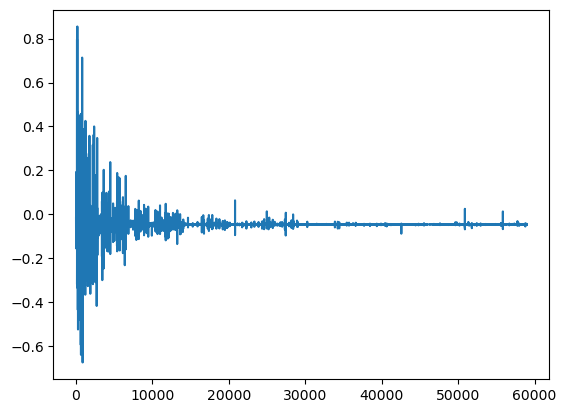

In [36]:
begin = 1000
end = begin + 1000000
plt.plot(np.array(current_df_eye_wavelet['Pupil_left'].iloc[begin:end]))

In [37]:
dict_data_eye['XCVN']

array([[ 1.40511042e+00,  1.57601627e+00,  6.55558314e-01,
        -2.10292435e-01,  1.47333333e-03],
       [ 1.39285720e+00,  1.56828201e+00,  6.52407818e-01,
        -2.15859081e-01,  1.47333333e-03],
       [ 1.38060397e+00,  1.56054775e+00,  6.49257321e-01,
        -2.21425727e-01,  1.47333333e-03],
       ...,
       [-1.68383986e-01, -3.44018314e-02, -5.06218740e-01,
        -4.70732975e-01,  1.47333333e-03],
       [-1.69332230e-01, -3.89013584e-02, -4.90382573e-01,
        -4.69173028e-01,  1.47333333e-03],
       [-1.70280475e-01, -4.34008854e-02, -4.74546406e-01,
        -4.67613080e-01,  1.47333333e-03]])

# Generate Individual Samples

In [38]:
def get_per_id_per_task_data(id, game):
    if game == 'enumeration':
        current_df_game = df_enumeration[(df_enumeration['userid'] == id) & (df_enumeration['Task_type'] == game)].copy()
    elif game == 'task_switching':
        current_df_game = df_ts[(df_ts['userid'] == id) & (df_ts['Task_type'] == game)].copy()
    elif game == 'working_memory':
        current_df_game = df_wm[(df_wm['userid'] == id) & (df_wm['Task_type'] == game)].copy()
    
    current_df_game['Start_time'] = current_df_game['Start_time'] / 1000 #convert milisecond to second
    current_df_game['End_time'] = current_df_game['End_time'] / 1000 #convert milisecond to second
    
    current_df_eye = df_eye[(df_eye['subject_id'] == id) & (df_eye['game_type'] == game)].copy()
    current_df_eye = current_df_eye.explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    current_df_eye = current_df_eye.replace('None', np.nan)
    current_df_eye = current_df_eye.astype({'Timestamp':'float64','Gaze_X':'float64','Gaze_Y':'float64','Pupil_left':'float64','Pupil_right':'float64'})

    current_df_ecg = df_ecg[(df_ecg['subject_id'] == id) & (df_ecg['game_type'] == game)].copy()
    current_df_ecg = current_df_ecg.explode(['Timestamp','ecg_data']).astype({'Timestamp':'float64','ecg_data': 'float64'})

    #up sampling for eye data
    basetime = min(current_df_eye['Timestamp'].iloc[0],current_df_ecg['Timestamp'].iloc[0]*1000)
    current_df_eye = resample_eye_to_250_hz(current_df_eye,basetime)
    current_df_eye['Timestamp'] = current_df_eye['Timestamp']/1000
    current_df_eye[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']] = current_df_eye[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']].interpolate(method = 'linear', limit = 50, limit_direction='both') #interpolate
    
    return current_df_game, current_df_eye, current_df_ecg
    

In [39]:
def generate_samples(data, current_id, current_task):
    SAMPlE_DURATION = 10 #6 second
    FS = 250
    ECG_SAMPLE_SIZE = SAMPlE_DURATION * 2 #allow maximun 2 R peaks per second
    list_eye_data = []
    list_ecg_data = []
    #list_eye_data_wavelet = []
    list_ecg_data_feature = []
    list_difficulty = []
    list_accuracy = []
    list_task = []
    
    for current_diff in DIFFICULTY:
        current_df_difficulty = current_df_game[current_df_game['Difficulty'] == current_diff]
        #print(current_df_difficulty.shape)
    
        #generate sample
        begin = np.nan
        for i in range(len(current_df_difficulty)):
            #calculate begin and end, if the duration is less than SAMPlE_DURATION go to the next trial
            if np.isnan(begin):
                begin = current_df_difficulty['Start_time'].iloc[i]
            if i == (len(current_df_difficulty) - 1):
                #check if i is the last entry or not
                end = begin + SAMPlE_DURATION
            else:
                end = current_df_difficulty['Start_time'].iloc[i+1]

            
            #get the sample
            temp_df_eye = current_df_eye.query('Timestamp >= @begin and Timestamp <= @end').copy()
            temp_df_ecg = current_df_ecg.query('Timestamp >= @begin and Timestamp <= @end')
            current_acc = current_df_difficulty['Accuracy'].iloc[i]
            
            begin = np.nan #reset begin variable

            
            #sanity data
            if pd.isna(temp_df_eye).sum().sum() > 0 or pd.isna(temp_df_ecg).sum().sum() > 0:
                continue
            if temp_df_eye.shape[0] < 2 or temp_df_ecg.shape[0] < 2:
                continue


            
            #here is to calculate snr
            #calculate ecg
            temp_ecg = np.array(temp_df_ecg['ecg_data'])
            temp_time = np.array(temp_df_ecg['Timestamp'])
            try:
                hr_mean, mean_rr, sd_rr, hrv, sd1, sd2, r_sd1_2, pnn50, snr_values, vlf_power, lf_power, hf_power, r_lf_hf, hr_list, rr_interval_list, d_rr_interval_list = get_ecg_features(temp_ecg, temp_time,fs=FS)
            except ValueError:
                hr_mean = mean_rr = r_sd1_2 = pnn50 = snr_values = r_lf_hf = hr_list = rr_interval_list = -1 #mark invalid
                sd_rr = hrv = sd1 = sd2 = d_rr_interval_list = vlf_power = lf_power = hf_power = -200
            if (snr_values < 4) or (hr_mean > 180) or (hrv > 5000) or (len(d_rr_interval_list) < 4):
                hr_mean = mean_rr = r_sd1_2 = pnn50 = snr_values = r_lf_hf = hr_list = rr_interval_list = -1 #mark invalid
                sd_rr = hrv = sd1 = sd2 = d_rr_interval_list = vlf_power = lf_power = hf_power = -200
            
            # if (mean_rr < 0) or (sd_rr < 0) or (hrv < 0) or (sd1 < 0) or (sd2 < 0) or (r_sd1_2 < 0) or \
            # (pnn50 < 0) or (snr_values < 0) or (r_lf_hf < 0):
            #     print(f"hr_mean: {hr_mean:.2f}, mean_rr: {mean_rr:.2f}, sd_rr: {sd_rr:.2f}, hrv: {hrv:.2f}, \n\
            #     sd1: {sd1:.2f}, sd2: {sd2:.2f}, r_sd1_2: {r_sd1_2:.2f}, pnn50: {pnn50:.2f}, snr_values: {snr_values:.2f},\n\
            #     vlf_power: {vlf_power:.2f}, lf_power: {lf_power:.2f}, hf_power: {hf_power:.2f}, r_lf_hf: {r_lf_hf:.2f},\n\
            #     hr_list: {hr_list.shape}, rr_interval_list: {rr_interval_list.shape}, d_rr_interval_list: {d_rr_interval_list.shape}, ecg_data: {ecg_sample_data.shape}")
            
            
            hr_mean_scaled = hr_scaler.transform(np.array(hr_mean).reshape(-1,1))[0][0]
            mean_rr_scaled = rr_scaler.transform(np.array(mean_rr).reshape(-1,1))[0][0]
            sd_rr_scaled   = d_rr_scaler.transform(np.array(sd_rr).reshape(-1,1))[0][0]
            hrv_scaled     = d_rr_scaler.transform(np.array(hrv).reshape(-1,1))[0][0]
            sd1_scaled     = d_rr_scaler.transform(np.array(sd1).reshape(-1,1))[0][0]
            sd2_scaled     = d_rr_scaler.transform(np.array(sd2).reshape(-1,1))[0][0]
            r_sd1_2           #no scaling need
            pnn50             #no scaling need
            snr_values        #no scaling need
            vlf_power_scaled= freq_scaler.transform(np.array(vlf_power).reshape(-1,1))[0][0]
            lf_power_scaled = freq_scaler.transform(np.array(lf_power).reshape(-1,1))[0][0]
            hf_power_scaled = freq_scaler.transform(np.array(hf_power).reshape(-1,1))[0][0]
            r_lf_hf        #no scaling need
      
            ecg_sample_feature = [hr_mean_scaled, mean_rr_scaled, sd_rr_scaled, hrv_scaled, sd1_scaled, sd2_scaled, r_sd1_2, pnn50, snr_values, vlf_power_scaled, lf_power_scaled, hf_power_scaled, r_lf_hf]
            #ecg_sample_feature = [hr_mean, mean_rr, sd_rr, hrv, sd1, sd2, r_sd1_2, pnn50, snr_values, vlf_power, lf_power, hf_power, r_lf_hf]
            
            # ecg padding
            temp_ecg_scaled = StandardScaler().fit_transform(temp_ecg.reshape(-1,1)).reshape(-1)
            ecg_list, ecg_padding           = pad_array(np.array(temp_ecg_scaled),FS * SAMPlE_DURATION)
            ecg_sample_data = np.array([ecg_list, ecg_padding]).T
            
            #standardization
            temp_df_eye[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']]         = dict_scaler_eye[current_id].transform(temp_df_eye[['Gaze_X','Gaze_Y','Pupil_left','Pupil_right']])

            #padding eye
            gaze_x_list, gaze_x_padding           = pad_array(np.array(temp_df_eye['Gaze_X']),FS * SAMPlE_DURATION)
            gaze_y_list, gaze_y_padding           = pad_array(np.array(temp_df_eye['Gaze_Y']),FS * SAMPlE_DURATION)
            pupil_l_list, pupil_l_padding         = pad_array(np.array(temp_df_eye['Pupil_left']),FS * SAMPlE_DURATION)
            pupil_r_list, pupil_r_padding         = pad_array(np.array(temp_df_eye['Pupil_right']),FS * SAMPlE_DURATION)
            eye_sample_data = np.array([pupil_l_list, pupil_r_list, gaze_x_list, gaze_y_list, pupil_l_padding, pupil_r_padding, gaze_x_padding,gaze_y_padding]).T

            # print('\n\nNew Sample:')
            # print(f'i: {i}, acc: {current_acc} , eye:{temp_df_eye.shape}, ecg:{temp_df_ecg.shape}, eye: {eye_sample_data.shape} ,ecg: {ecg_sample_data.shape}')
            # print(ecg_sample_feature)
            # print(ecg_sample_data)
            # print(eye_sample_data)

            
            list_eye_data.append(np.array(eye_sample_data))
            #list_eye_data_wavelet.append(np.array(temp_df_eye_wavelet[['Pupil_left','Pupil_right','Gaze_X','Gaze_Y']]))
            list_ecg_data.append(np.array(ecg_sample_data))
            list_ecg_data_feature.append(np.array(ecg_sample_feature))

            # print(f"hr_mean: {hr_mean:.2f}, mean_rr: {mean_rr:.2f}, sd_rr: {sd_rr:.2f}, hrv: {hrv:.2f}, \n\
            # sd1: {sd1:.2f}, sd2: {sd2:.2f}, r_sd1_2: {r_sd1_2:.2f}, pnn50: {pnn50:.2f}, snr_values: {snr_values:.2f},\n\
            # vlf_power: {vlf_power:.2f}, lf_power: {lf_power:.2f}, hf_power: {hf_power:.2f}, r_lf_hf: {r_lf_hf:.2f},\n\
            # hr_list: {hr_list.shape}, rr_interval_list: {rr_interval_list.shape}, d_rr_interval_list: {d_rr_interval_list.shape}, ecg_data: {ecg_sample_data.shape}")



            #Generate Y data
            if current_diff == 'Easy':
                list_difficulty.append(0)
            elif current_diff == 'Medium':
                list_difficulty.append(1)
            elif current_diff == 'Hard':
                list_difficulty.append(2)
            list_accuracy.append(current_acc)
            list_task.append(current_task)
            
    
    list_eye_data = np.array(list_eye_data)
    #list_eye_data_wavelet = np.array(list_eye_data_wavelet)
    list_ecg_data = np.array(list_ecg_data)
    list_ecg_data_feature = np.array(list_ecg_data_feature)
    
    list_difficulty = np.array(list_difficulty)
    list_accuracy = np.array(list_accuracy)
    list_task = np.array(list_task)
    
    return list_eye_data, list_ecg_data, list_ecg_data_feature, list_difficulty, list_accuracy, list_task


In [40]:
dict_sample_data_eye = {}
# dict_sample_data_eye_wavelet = {}
dict_sample_data_ecg = {}
dict_sample_data_ecg_feature = {}
dict_sample_difficulty = {}
dict_sample_accuracy = {}
dict_sample_task_type = {}


for current_id in UNIQUE_SID:
    dict_sample_data_eye[current_id] = []
    # dict_sample_data_eye_wavelet[current_id] = []
    dict_sample_data_ecg[current_id] = []
    dict_sample_data_ecg_feature[current_id] = []
    dict_sample_difficulty[current_id] = []
    dict_sample_accuracy[current_id] = []
    dict_sample_task_type[current_id] = []
    
    for current_task in TASKTYPE:
        #get the current data
        current_df_game, current_df_eye, current_df_ecg = get_per_id_per_task_data(current_id, current_task)
        # print(f'ID:{current_id}, task:{current_task}, eye:{current_df_eye.shape}, ecg:{current_df_ecg.shape}, game:{current_df_game.shape}\n')
        if current_df_game.shape[0] == 0:
            continue

        list_eye_data, list_ecg_data, list_ecg_data_feature, list_difficulty, list_accuracy, list_task = generate_samples(current_df_game, current_id, current_task)
        
        dict_sample_data_eye[current_id].extend(list_eye_data)
        # dict_sample_data_eye_wavelet[current_id].extend(list_eye_data_wavelet)
        dict_sample_data_ecg[current_id].extend(list_ecg_data)
        dict_sample_data_ecg_feature[current_id].extend(list_ecg_data_feature)
        dict_sample_difficulty[current_id].extend(list_difficulty)
        dict_sample_accuracy[current_id].extend(list_accuracy)
        dict_sample_task_type[current_id].extend(list_task)

    
    #end task loop
    
    dict_sample_data_eye[current_id] = np.array(dict_sample_data_eye[current_id])
    # dict_sample_data_eye_wavelet[current_id] = np.array(dict_sample_data_eye_wavelet[current_id])
    dict_sample_data_ecg[current_id] = np.array(dict_sample_data_ecg[current_id])
    dict_sample_data_ecg_feature[current_id] = np.array(dict_sample_data_ecg_feature[current_id])
    dict_sample_difficulty[current_id] = np.array(dict_sample_difficulty[current_id])
    dict_sample_accuracy[current_id] = np.array(dict_sample_accuracy[current_id])
    dict_sample_task_type[current_id] = np.array(dict_sample_task_type[current_id])
    
    print(f'eye: {dict_sample_data_eye[current_id].shape}, ecg: {dict_sample_data_ecg[current_id].shape}, \
    difficulty: {dict_sample_difficulty[current_id].shape}, Acc: {dict_sample_accuracy[current_id].shape}, \
    ecg_feature: {dict_sample_data_ecg_feature[current_id].shape}, task: {dict_sample_task_type[current_id].shape}')
   
#end sid loop

    

eye: (362, 2500, 8), ecg: (362, 2500, 2),     difficulty: (362,), Acc: (362,),     ecg_feature: (362, 13), task: (362,)
eye: (324, 2500, 8), ecg: (324, 2500, 2),     difficulty: (324,), Acc: (324,),     ecg_feature: (324, 13), task: (324,)
eye: (348, 2500, 8), ecg: (348, 2500, 2),     difficulty: (348,), Acc: (348,),     ecg_feature: (348, 13), task: (348,)
eye: (318, 2500, 8), ecg: (318, 2500, 2),     difficulty: (318,), Acc: (318,),     ecg_feature: (318, 13), task: (318,)
eye: (349, 2500, 8), ecg: (349, 2500, 2),     difficulty: (349,), Acc: (349,),     ecg_feature: (349, 13), task: (349,)
eye: (348, 2500, 8), ecg: (348, 2500, 2),     difficulty: (348,), Acc: (348,),     ecg_feature: (348, 13), task: (348,)
eye: (360, 2500, 8), ecg: (360, 2500, 2),     difficulty: (360,), Acc: (360,),     ecg_feature: (360, 13), task: (360,)
eye: (323, 2500, 8), ecg: (323, 2500, 2),     difficulty: (323,), Acc: (323,),     ecg_feature: (323, 13), task: (323,)
eye: (355, 2500, 8), ecg: (355, 2500, 2)

In [41]:
list_ecg_data[0][:60]

array([[ 3.26000378e-01,  1.00000000e+00],
       [ 5.98273229e-01,  1.00000000e+00],
       [ 3.80454948e-01,  1.00000000e+00],
       [ 4.89364088e-01,  1.00000000e+00],
       [ 4.34909518e-01,  1.00000000e+00],
       [ 6.89030846e-01,  1.00000000e+00],
       [ 4.53061042e-01,  1.00000000e+00],
       [ 5.61970182e-01,  1.00000000e+00],
       [ 4.71212565e-01,  1.00000000e+00],
       [ 7.25333893e-01,  1.00000000e+00],
       [ 6.34576276e-01,  1.00000000e+00],
       [ 5.07515612e-01,  1.00000000e+00],
       [ 5.61970182e-01,  1.00000000e+00],
       [ 6.16424752e-01,  1.00000000e+00],
       [ 5.61970182e-01,  1.00000000e+00],
       [ 3.98606471e-01,  1.00000000e+00],
       [ 3.44151901e-01,  1.00000000e+00],
       [ 3.44151901e-01,  1.00000000e+00],
       [ 3.26000378e-01,  1.00000000e+00],
       [ 3.55760034e-02,  1.00000000e+00],
       [-5.51816136e-02,  1.00000000e+00],
       [-1.82242277e-01,  1.00000000e+00],
       [-1.45939231e-01,  1.00000000e+00],
       [-3.

In [42]:
sum = 0
for key in dict_sample_difficulty.keys():
    sum += dict_sample_difficulty[key].shape[0]
sum

33564

In [43]:
current_df_game

,userid,BlockNo,Difficulty,Start_time,End_time,Results_responses,Results_rt,Results_targetvalue_stim,Results_num_stim,Results_correct,Correct Answer,Accuracy,Task_type,Accuracy_Easy,Accuracy_Medium,Accuracy_Hard,Accuracy_Overall
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2467.0,9-10-11-1-4-0-6-13-3-12-5-8-14-2-7-15,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2700.0,8-1-4-5-2-15-3-14-12-10-9-6-0-11-13-7,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2283.0,7-13-2-6-3-8-5-4-15-10-0-12-9-11-14-1,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2666.0,7-13-12-6-0-5-1-15-11-4-2-14-3-8-10-9,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2422.0,4-0-11-5-8-1-15-2-10-13-7-6-14-12-9-3,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,1983.0,3-1-0-15-14-4-11-13-12-5-7-6-10-9-2-8,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2034.0,9-12-15-8-7-5-1-4-2-3-10-11-13-0-6-14,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2218.0,3-13-2-5-10-15-14-11-7-8-9-12-6-1-4-0,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2667.0,3-11-8-9-13-0-12-15-7-10-6-4-2-1-14-5,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,1831.0,11-7-10-15-8-12-14-2-6-3-0-9-4-13-5-1,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575


In [44]:
current_df_ecg

,subject_id,game_type,Timestamp,ecg_data
199,TYZX,working_memory,1.710348e+09,315.0
199,TYZX,working_memory,1.710348e+09,190.0
199,TYZX,working_memory,1.710348e+09,90.0
199,TYZX,working_memory,1.710348e+09,78.0
199,TYZX,working_memory,1.710348e+09,81.0
...,...,...,...,...
199,TYZX,working_memory,1.710349e+09,181.0
199,TYZX,working_memory,1.710349e+09,194.0
199,TYZX,working_memory,1.710349e+09,192.0
199,TYZX,working_memory,1.710349e+09,192.0


In [45]:
current_df_game

,userid,BlockNo,Difficulty,Start_time,End_time,Results_responses,Results_rt,Results_targetvalue_stim,Results_num_stim,Results_correct,Correct Answer,Accuracy,Task_type,Accuracy_Easy,Accuracy_Medium,Accuracy_Hard,Accuracy_Overall
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2467.0,9-10-11-1-4-0-6-13-3-12-5-8-14-2-7-15,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2700.0,8-1-4-5-2-15-3-14-12-10-9-6-0-11-13-7,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2283.0,7-13-2-6-3-8-5-4-15-10-0-12-9-11-14-1,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2666.0,7-13-12-6-0-5-1-15-11-4-2-14-3-8-10-9,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2422.0,4-0-11-5-8-1-15-2-10-13-7-6-14-12-9-3,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,1983.0,3-1-0-15-14-4-11-13-12-5-7-6-10-9-2-8,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2034.0,9-12-15-8-7-5-1-4-2-3-10-11-13-0-6-14,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2,2218.0,3-13-2-5-10-15-14-11-7-8-9-12-6-1-4-0,3.0,1.0,0-1-2,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,2667.0,3-11-8-9-13-0-12-15-7-10-6-4-2-1-14-5,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575
48,TYZX,1,Easy,1.710348e+09,1.710348e+09,0-1-2-3,1831.0,11-7-10-15-8-12-14-2-6-3-0-9-4-13-5-1,4.0,1.0,0-1-2-3,1.0,working_memory,0.95,0.885,0.7375,0.8575


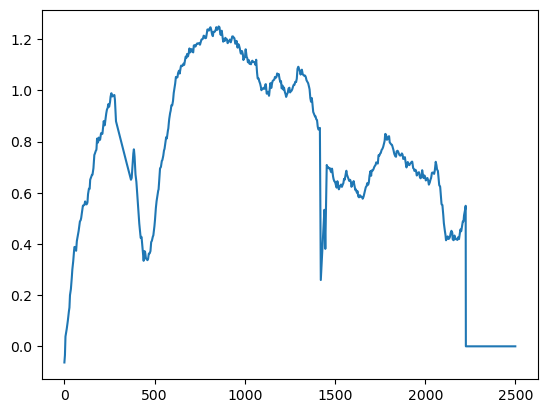

In [46]:
plt.plot(dict_sample_data_eye['XCVN'][0][:,0])

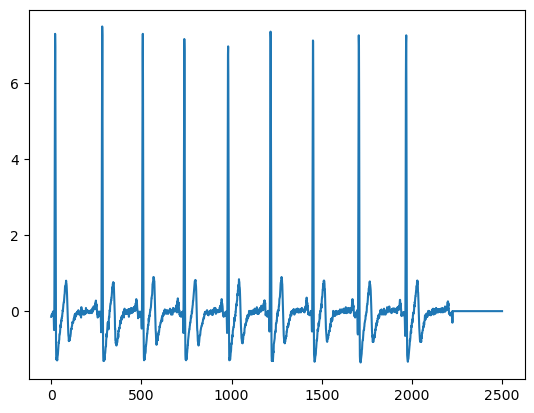

In [47]:
plt.plot(dict_sample_data_ecg['XCVN'][0][:,0])

In [48]:
dict_sample_data_ecg_feature['XCVN'][0]

array([-1.61347591,  1.6992081 , -0.09427181, -0.09897379, -0.15749832,
       -0.2725066 ,  1.13254897,  0.4       ,  8.33139698, -0.18640579,
       -0.18640579, -0.18171679,  0.        ])

In [49]:
dict_sample_accuracy

{'XCVN': array([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    

# Save Data

In [50]:
SUBLIST_SID

[array(['XCVN', 'NVBX', 'TGVB', 'LKJH', 'ZRTY', 'UIOP', 'JKLZ', 'XRTY',
        'MNBW', 'HJKL', 'JKZX', 'NMJU', 'YUZW', 'BHGY', 'QAZW', 'QXZW',
        'CVBN', 'ZXNM', 'UJNH', 'FTLD'], dtype=object),
 array(['GHJK', 'KJHG', 'ZXCJ', 'NMKL', 'SVTZM', 'AXSW', 'VNPL', 'PKJH',
        'XZPT', 'QWRT', 'SRKLP', 'REWQ', 'RQWE', 'STWXJ', 'SNMVN', 'WERT',
        'FYDR', 'SJWQP', 'HPLX', 'NBVC'], dtype=object),
 array(['SPKZR', 'ZXWE', 'SLMJK', 'GHFJ', 'FTYP', 'DFZX', 'LPZV', 'MJKL',
        'SXVBN', 'UYGH', 'FDXC', 'UPLK', 'YTRE', 'MJUY', 'NMBV', 'FGHZ',
        'WZXE', 'QWER', 'VFTY', 'MTYH'], dtype=object),
 array(['ZYXW', 'MYTZ', 'DFGH', 'PLRQ', 'FDSA', 'QPLM', 'LKPW', 'NHZA',
        'RTGH', 'JFDE', 'MNOP', 'ZXCV', 'VBNM', 'POIU', 'GTYU', 'UYTR',
        'DKLQ', 'LKMN', 'SBQRG'], dtype=object),
 array(['LPDW', 'SBTBT', 'SHYXZ', 'JKLM', 'PLMO', 'XUYP', 'LRTB', 'XCVH',
        'TYDF', 'EDFR', 'QPOI', 'JHGF', 'RIQW', 'QPMN', 'ZXAS', 'VIWZ',
        'OPKJ', 'QAXY', 'TYZX'], dtype=object)]

In [51]:
SUBLIST_SID = np.array(SUBLIST_SID, dtype=object)

In [52]:
np.save(f'sid_list_accuracy.npy', SUBLIST_SID)
SUBLIST_SID

array([array(['XCVN', 'NVBX', 'TGVB', 'LKJH', 'ZRTY', 'UIOP', 'JKLZ', 'XRTY',
              'MNBW', 'HJKL', 'JKZX', 'NMJU', 'YUZW', 'BHGY', 'QAZW', 'QXZW',
              'CVBN', 'ZXNM', 'UJNH', 'FTLD'], dtype=object)                 ,
       array(['GHJK', 'KJHG', 'ZXCJ', 'NMKL', 'SVTZM', 'AXSW', 'VNPL', 'PKJH',
              'XZPT', 'QWRT', 'SRKLP', 'REWQ', 'RQWE', 'STWXJ', 'SNMVN', 'WERT',
              'FYDR', 'SJWQP', 'HPLX', 'NBVC'], dtype=object)                   ,
       array(['SPKZR', 'ZXWE', 'SLMJK', 'GHFJ', 'FTYP', 'DFZX', 'LPZV', 'MJKL',
              'SXVBN', 'UYGH', 'FDXC', 'UPLK', 'YTRE', 'MJUY', 'NMBV', 'FGHZ',
              'WZXE', 'QWER', 'VFTY', 'MTYH'], dtype=object)                   ,
       array(['ZYXW', 'MYTZ', 'DFGH', 'PLRQ', 'FDSA', 'QPLM', 'LKPW', 'NHZA',
              'RTGH', 'JFDE', 'MNOP', 'ZXCV', 'VBNM', 'POIU', 'GTYU', 'UYTR',
              'DKLQ', 'LKMN', 'SBQRG'], dtype=object)                        ,
       array(['LPDW', 'SBTBT', 'SHYXZ', 'JKLM', 

In [53]:
for index, id_list in enumerate(SUBLIST_SID):
    print(index, ':  ',id_list)
    X_list = []
    Y_list = []
    for current_id in id_list:
        X_0     = dict_data_demo[current_id]
        X_1_eye = dict_data_eye[current_id]
        X_1_eye_wavelet = dict_data_eye_wavelet[current_id]
        X_1_ecg = dict_data_ecg[current_id]
        X_1_ecg_feature = dict_data_ecg_feature[current_id]

        list_X_2_eye = dict_sample_data_eye[current_id]
        list_X_2_ecg = dict_sample_data_ecg[current_id]
        list_X_2_ecg_feature = dict_sample_data_ecg_feature[current_id]
        list_Y_diff =  dict_sample_difficulty[current_id]
        list_Y_acc  =  dict_sample_accuracy[current_id]
        list_Y_task =  dict_sample_task_type[current_id]
        
        for i in range(len(list_X_2_eye)):
            X_2_eye = list_X_2_eye[i]
            X_2_ecg = list_X_2_ecg[i]
            X_2_ecg_feature = list_X_2_ecg_feature[i]
            Y_diff =  list_Y_diff[i]
            Y_acc  =  list_Y_acc[i]         
            Y_task =  list_Y_task[i]
            
            #print(f'eye: {X_2_eye.shape}, ecg: {X_2_ecg.shape}, Y_diff: {Y_diff}, Y_acc: {Y_acc}')
            X = (X_0, X_1_eye, X_1_eye_wavelet, X_1_ecg, X_1_ecg_feature, X_2_eye, X_2_ecg, X_2_ecg_feature)
            X_list.append(X)

            Y = (Y_diff,Y_acc,Y_task)
            Y_list.append(Y)

    X_list = np.array(X_list, dtype=object)
    Y_list = np.array(Y_list, dtype=object)
    print(X_list.shape, '  ', Y_list.shape) 
    
    np.save(f'X_fold{index}_accuracy.npy', X_list)
    np.save(f'Y_fold{index}_accuracy.npy', Y_list)
    


0 :   ['XCVN' 'NVBX' 'TGVB' 'LKJH' 'ZRTY' 'UIOP' 'JKLZ' 'XRTY' 'MNBW' 'HJKL'
 'JKZX' 'NMJU' 'YUZW' 'BHGY' 'QAZW' 'QXZW' 'CVBN' 'ZXNM' 'UJNH' 'FTLD']
(6665, 8)    (6665, 3)
1 :   ['GHJK' 'KJHG' 'ZXCJ' 'NMKL' 'SVTZM' 'AXSW' 'VNPL' 'PKJH' 'XZPT' 'QWRT'
 'SRKLP' 'REWQ' 'RQWE' 'STWXJ' 'SNMVN' 'WERT' 'FYDR' 'SJWQP' 'HPLX' 'NBVC']
(6859, 8)    (6859, 3)
2 :   ['SPKZR' 'ZXWE' 'SLMJK' 'GHFJ' 'FTYP' 'DFZX' 'LPZV' 'MJKL' 'SXVBN' 'UYGH'
 'FDXC' 'UPLK' 'YTRE' 'MJUY' 'NMBV' 'FGHZ' 'WZXE' 'QWER' 'VFTY' 'MTYH']
(7025, 8)    (7025, 3)
3 :   ['ZYXW' 'MYTZ' 'DFGH' 'PLRQ' 'FDSA' 'QPLM' 'LKPW' 'NHZA' 'RTGH' 'JFDE'
 'MNOP' 'ZXCV' 'VBNM' 'POIU' 'GTYU' 'UYTR' 'DKLQ' 'LKMN' 'SBQRG']
(6501, 8)    (6501, 3)
4 :   ['LPDW' 'SBTBT' 'SHYXZ' 'JKLM' 'PLMO' 'XUYP' 'LRTB' 'XCVH' 'TYDF' 'EDFR'
 'QPOI' 'JHGF' 'RIQW' 'QPMN' 'ZXAS' 'VIWZ' 'OPKJ' 'QAXY' 'TYZX']
(6514, 8)    (6514, 3)
